In [2]:
from __future__ import division
%matplotlib inline
import numpy as np
from numpy.random import rand
import pandas as pd
import seaborn as sns
import pylab as plt
import matplotlib.gridspec as gridspec
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as conf_m
import csv
import time

In [4]:
def initialstate(N):
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

def mcmove_csv(config, beta):
    f = open('MC_train_data_reduced.csv', 'w')
    writer = csv.writer(f)
    writer.writerow(["s","lr","ud","R"])
    for i in range(N):
        for j in range(N):
                r=1
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b]*0.6 + config[(a-1)%N,b]*0.6 + config[a,(b+1)%N] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    r = -1
                elif rand() < np.exp(-cost*beta):
                    r = -1
                writer.writerow([config[a,b],\
                                 config[(a-1)%N,b]+config[(a+1)%N,b],\
                                 config[a,(b+1)%N]+config[a,(b-1)%N],\
                                 config[a,b]*r])
                s*=r
                config[a, b] = s
    f.close()
    return config

def mcmove(config, beta):
    for i in range(N):
        for j in range(N):
                r=1
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b]*0.6 + config[(a-1)%N,b]*0.6 + config[a,(b+1)%N] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    r = -1
                elif rand() < np.exp(-cost*beta):
                    r = -1
                s*=r
                config[a, b] = s
    return config

def flip_ML_reduced(configuration,coords):
    N=np.shape(configuration)[0]
    for x in coords:
        #inp=[configuration[x[0]%N,x[1]%N],configuration[(x[0]-1)%N,x[1]%N]+configuration[(x[0]+1)%N,x[1]%N],configuration[x[0]%N,(x[1]-1)%N]+configuration[x[0]%N,(x[1]+1)%N]]
        inp=[configuration[x[0]%N,x[1]%N],configuration[(x[0]-1)%N,x[1]%N]+configuration[(x[0]+1)%N,x[1]%N],configuration[x[0]%N,(x[1]-1)%N]+configuration[x[0]%N,(x[1]+1)%N]]
        inp=np.array(inp)#.reshape(1,-1)
        configuration[x[0],x[1]]=np.sign(clf.predict([inp])-0.5)[0]
    return configuration

def configPlot(configuration):
    X, Y = np.meshgrid(range(N), range(N))    
    plt.pcolormesh(X, Y, configuration, cmap=plt.cm.RdBu);

In [3]:
N=1000
temp = 10
config = initialstate(N)
conf=mcmove_csv(config, temp)

In [2]:
data=pd.read_csv("MC_train_data_reduced.csv")
y=data["R"]
X=data[["s","lr","ud"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predict=clf.predict(X_test)

print("Standard deviation of difference between predicted and test data: ",np.std(predict-y_test))

Standard deviation of difference between predicted and test data:  0.0


In [7]:
y_test.values

array([ 1, -1, -1, ...,  1,  1, -1])

In [8]:
conf_m(y_test.values, predict)

array([[ 99782,      0],
       [     0, 100218]])

Text(0, 0.5, 'eps')

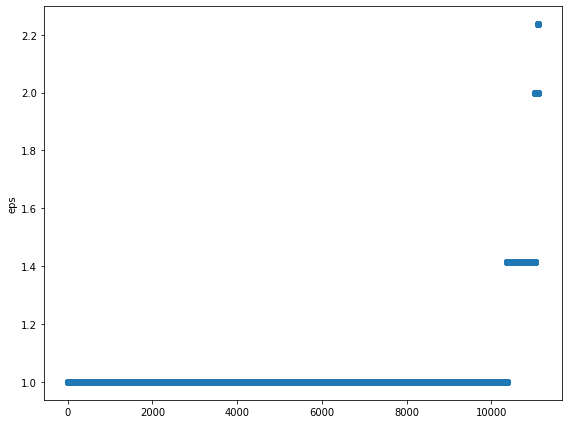

In [59]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
config_ml = initialstate(N)

config_ml_sgn=np.argwhere(config_ml==1)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(config_ml_sgn)
distances, indices = nbrs.kneighbors(config_ml_sgn)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, "o")
plt.ylabel("eps")

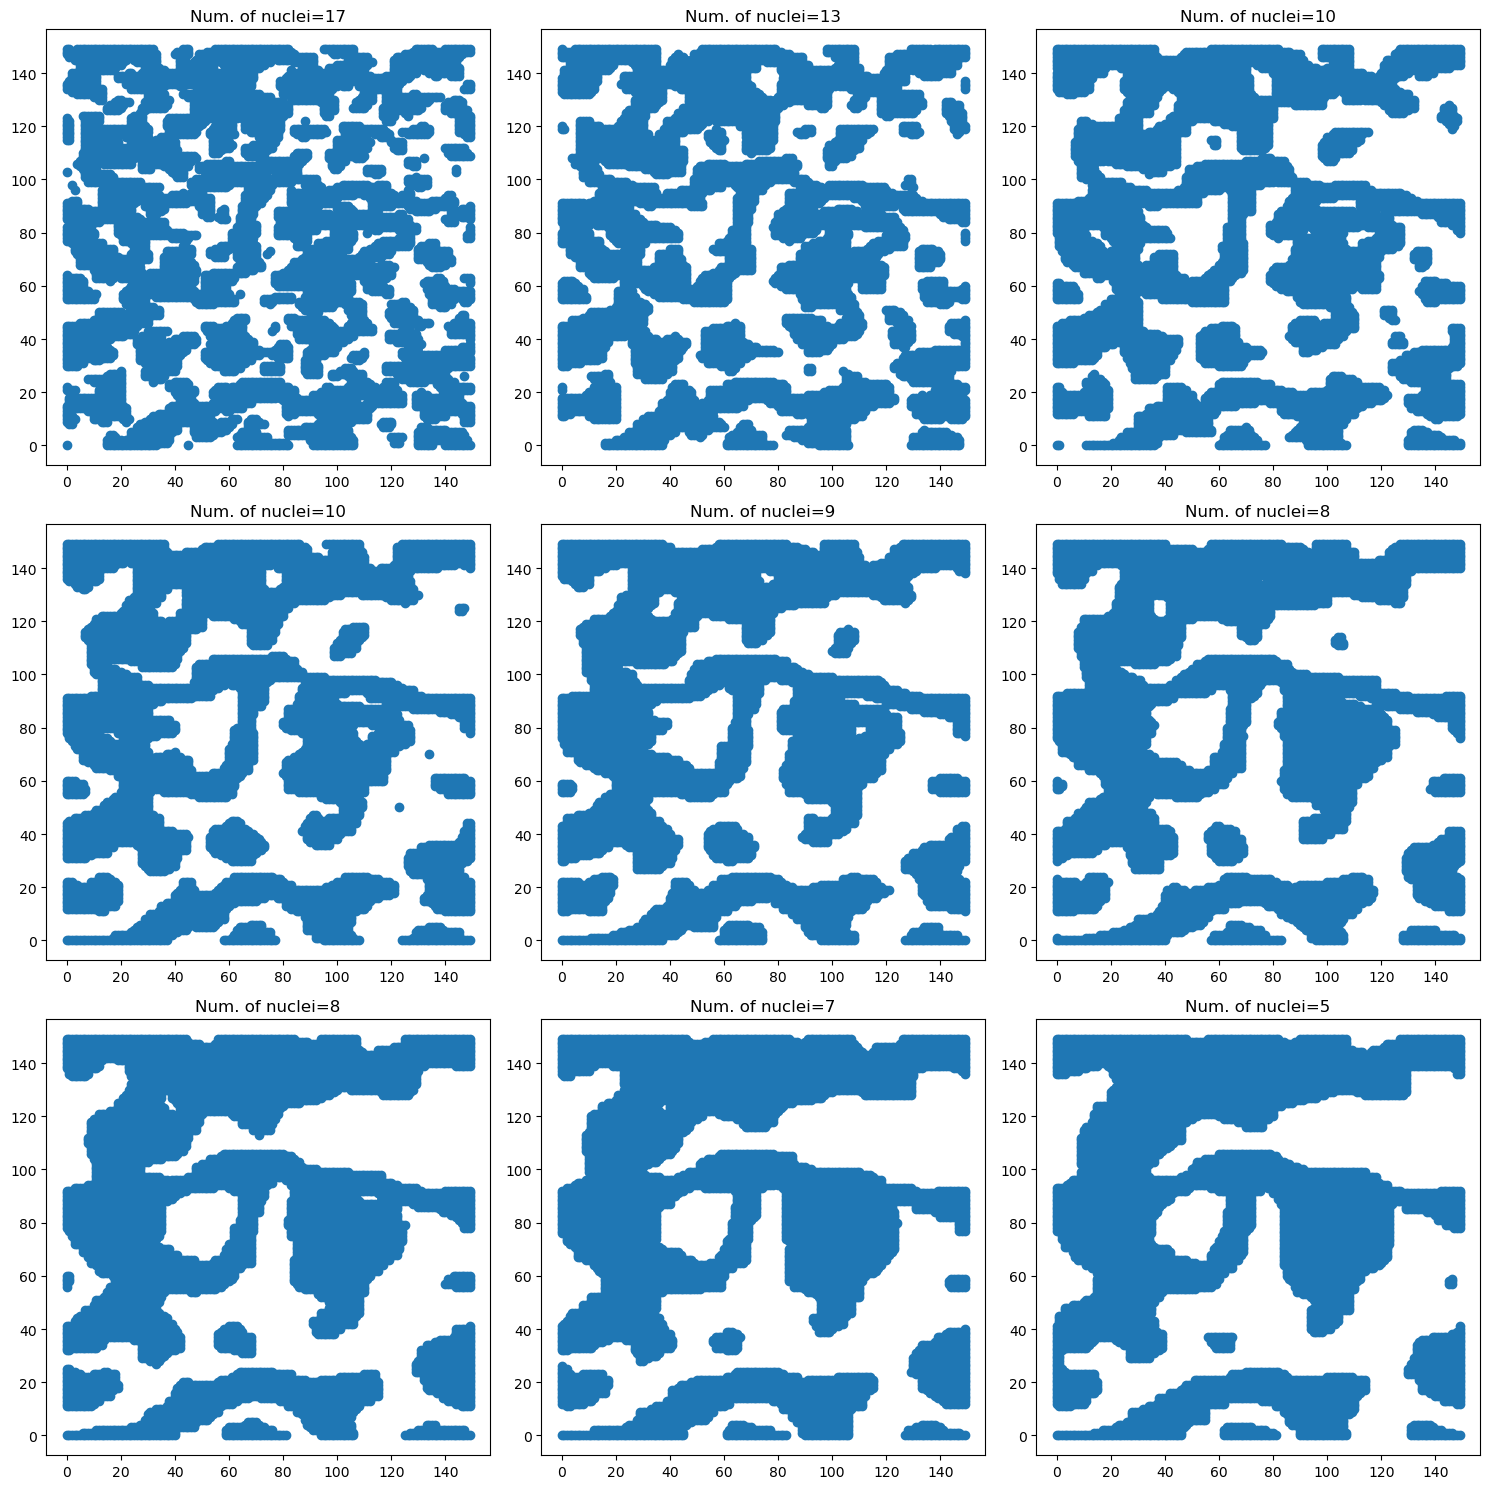

In [36]:
fig = plt.figure(figsize=(15, 15), tight_layout=True)
n1,n2= 3, 3
gs = gridspec.GridSpec(n1, n2)
N = 150
config_ml = initialstate(N)
for i in range(n1):
    for j in range(n2):

        for _ in range(10):
            config_ml=mcmove(config_ml,15)
        config_ml_sgn=np.argwhere(config_ml==1)

        db = DBSCAN(eps=1.0, min_samples=3).fit(config_ml_sgn)
        labels = db.labels_

        add_nuc=0
        for s in set(labels):
            cluster_size=len(np.argwhere(labels==s)[:,0])
            if cluster_size>40:
                add_nuc+=1

        ax = fig.add_subplot(gs[i, j])
        plt.title('Num. of nuclei=%d'%add_nuc)
        #sns.scatterplot(x=config_ml_sgn[:,1], y=config_ml_sgn[:,0], hue=["cluster-{}".format(x) for x in labels])
        plt.scatter(config_ml_sgn[:,1], config_ml_sgn[:,0])

plt.show()

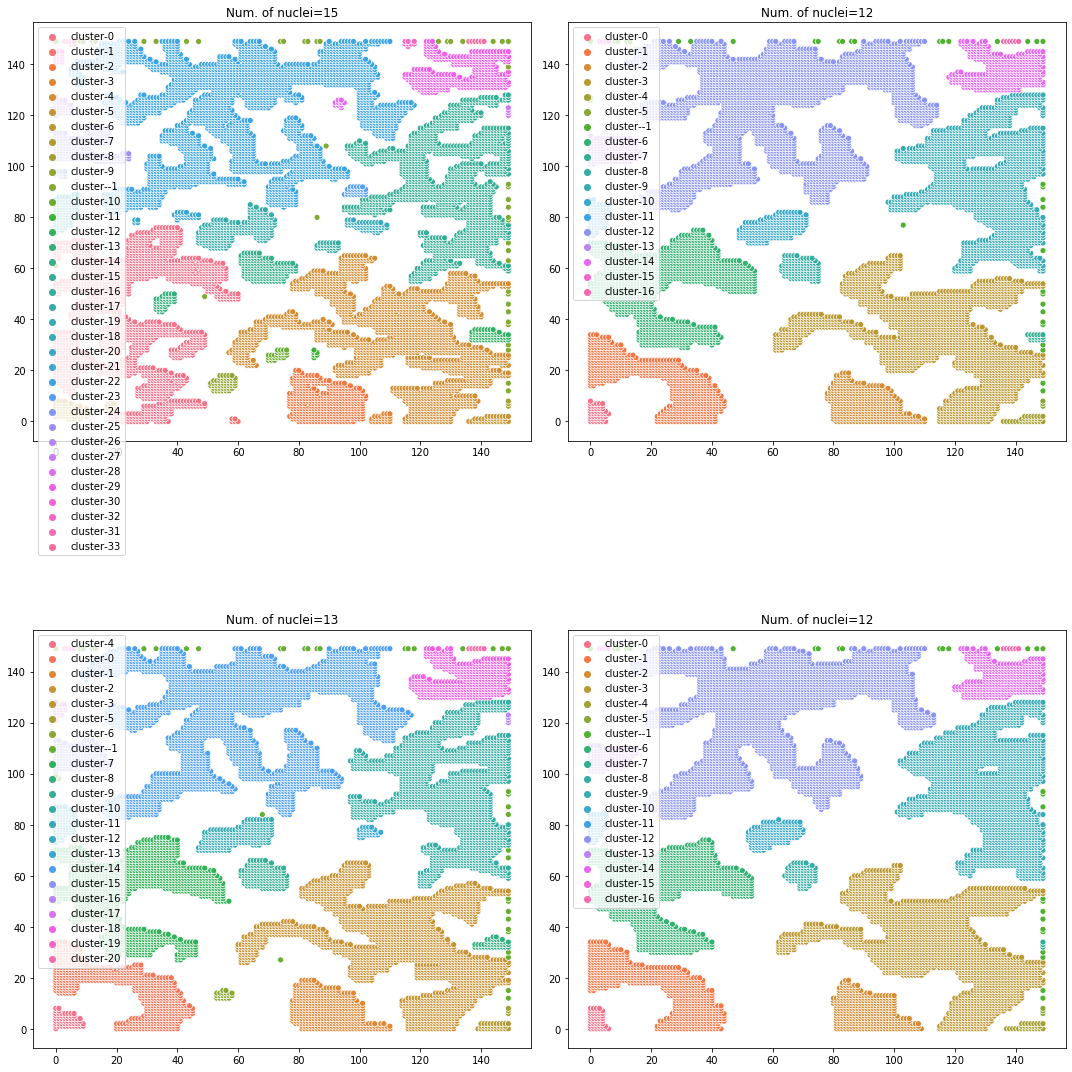

In [58]:
fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = gridspec.GridSpec(2, 2)
N = 150
config_ml = initialstate(N)
for j in range(2):
    for i in range(2):

        for _ in range(10):
            config_ml=flip_ML_reduced(config_ml,np.random.randint(N-1, size=(N**2, 2)))
        config_ml_sgn=np.argwhere(config_ml==1)

        db = DBSCAN(eps=1.0, min_samples=3).fit(config_ml_sgn)
        labels = db.labels_

        add_nuc=0
        for s in set(labels):
            cluster_size=len(np.argwhere(labels==s)[:,0])
            if cluster_size>40:
                add_nuc+=1

        ax = fig.add_subplot(gs[i, j])
        plt.title('Num. of nuclei=%d'%add_nuc)
        sns.scatterplot(config_ml_sgn[:,1], config_ml_sgn[:,0], hue=["cluster-{}".format(x) for x in labels])

plt.show()

In [39]:
%time
I1,I2 = 1,1
config_opt = {}
for i in [-1,1]:
    for j in [-1,1]:
        for k in [-1,1]:
            for l in [-1,1]:
                for n in [-1,1]:
                    cost = 2*n*((i+j)*I1 + (k+l)*I2)
                    config_opt[f'{i}{j}{k}{l}{n}'] = np.exp(-cost/10)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.1 µs


In [40]:
def initialstate(N):
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

def mcmove2(config, beta):
    for i in range(N):
        for j in range(N):
                r=1
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                cost = config_opt[f'{config[(a+1)%N,b]}{config[(a-1)%N,b]}{config[a,(b+1)%N]}{config[a,(b-1)%N]}{s}']
                if rand() < cost:
                    r = -1
                s*=r
                config[a, b] = s
    return config

def mcmove(config, beta):
    for i in range(N):
        for j in range(N):
                r=1
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b]*0.6 + config[(a-1)%N,b]*0.6 + config[a,(b+1)%N] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    r = -1
                elif rand() < np.exp(-cost*beta):
                    r = -1
                s*=r
                config[a, b] = s
    return config

In [42]:
st = time.time()
N=500
temp = 100
config = initialstate(N)
for i in range(50):
    mcmove(config, 2)
time.time()-st

256.44451117515564

In [43]:
st = time.time()
config = initialstate(N)
for i in range(50):
    mcmove2(config, 2)
time.time()-st

124.92748594284058